In [1]:
import numpy as np
import math
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
noise_max = 0.3
def make_xy_pair(shape):
    y = np.round(np.random.rand(*shape))
    noise = np.random.uniform(low=-noise_max/2, high=noise_max/2, size=(shape))
    x = y - noise
    return x, y

In [155]:
def trapezoidIntegral(vals, ds):
    pass1 = tf.reduce_sum(vals, axis=0)
    pass2 = tf.reduce_sum(vals[1:-1], axis=0)
    return ds/2.0*(pass1+pass2)
def TFconv(image, filt, b):
    return tf.nn.convolution(input=image, filters=filt, padding="SAME") + b
def leakyRelUInv(x):
    shape = x.shape
    zeros = tf.zeros(shape)
    mask = tf.math.greater_equal(x, zeros)
    weighted = x / leakyRelU_weight
    return tf.where(mask, x, weighted)
def uSoln(x0, inFilt, pFilt, b, y):
    t1 = inFilt.shape[0]
    ds = 1.0/(t1-1)
    input_shape = x0.shape
    bzero = tf.zeros([inFilt.shape[4]])
    x = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    u = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    
    with tf.GradientTape() as tape:
        tape.watch(x0)
        u0 = leakyRelUInv(x0)
        u = u.write(0,TFconv(u0, inFilt[0], bzero))

        for h in range(t1-1):
            x = x.write(h, tf.nn.leaky_relu(u.read(h), alpha=leakyRelU_weight))
            zInt = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
            for s in range(h+1):
                zInt = zInt.write(s, TFconv(x.read(s), pFilt[s,h], b[h] / ((h+1)*ds)))
            z = trapezoidIntegral(zInt.stack(), ds)
            u = u.write(h+1, z + TFconv(u0, inFilt[h+1], bzero))
        x = x.write(t1-1,tf.nn.leaky_relu(u.read(t1-1), alpha=leakyRelU_weight))
        
        loss = tf.math.square(x.read(t1-1) - y)
        gradients = tape.gradient(loss, [pFilt, inFilt, b])
        
        return x.read(t1-1), tf.math.reduce_sum(loss), gradients
def make_model(t0, input_shape, filter_shape):
    t1 = t0+1

    rng = np.random.default_rng(42)
    iFilt = rng.standard_normal((t1,*filter_shape), dtype=np.float32)
    #paramFilt = rng.standard_normal((t1,t1,*filter_shape), dtype=np.float32)
    p0 = np.array([[0.7,0.4,0.8,0.8,0.55],[0.35,0.3,0.25,0.2,0.45],[0.1,0.9,0.65,0.1,0.35],[0.2,0.15,0.95,0.65,0.9],[0.05,0.8,0.9,0.5,0.1]])
    p1 = np.expand_dims(p,(2,3,4,5)).astype(np.float32)
    biasVec = rng.uniform(0,1,(t1,1)).astype(dtype=np.float32)
    
    TFiFiltTensor = tf.transpose(tf.compat.v1.get_variable("iFiltTensor", initializer=iFilt), perm=[0,3,4,1,2])
    TFiFilt = tf.Variable(TFiFiltTensor, name="iFilt")
    TFpFiltTensor = tf.transpose(tf.compat.v1.get_variable("pFiltTensor", initializer=p1), perm=[0,1,4,5,2,3])
    TFpFilt = tf.Variable(TFpFiltTensor, name="pFilt")
    TFbiasVec = tf.compat.v1.get_variable("biasVec", initializer=biasVec)
    
    return (TFiFilt, TFpFilt, TFbiasVec)
def prepped_input(x):
    return tf.expand_dims(tf.transpose(tf.convert_to_tensor(x, dtype=tf.float32), perm=[1,2,0]), 0)
def prepped_output(y):
    return tf.expand_dims(tf.transpose(tf.convert_to_tensor(y, dtype=tf.float32), perm=[1,2,0]), 0)
def optimize(optimizer, xIn, iFilt, pFilt, bias, y):
    output, loss, grad = TFuSoln(xIn, iFilt, pFilt, bias, y)
    optimizer.apply_gradients(zip(grad, [pFilt, iFilt, bias]))
    return loss

In [4]:
TFuSoln = tf.function(uSoln)

In [156]:
learning_rate = 0.01
leakyRelU_weight = 0.1
opt = tf.keras.optimizers.Adam(learning_rate)
input_shape = (1,1,1)
filter_shape = (1,1,1,1)
t0 = 4

model = make_model(t0, input_shape, filter_shape)
#y = prepped_output(np.random.rand(*input_shape).astype(np.float32))


iterations = 200
losses = []
for i in np.arange(iterations):
    #npx, npy = make_xy_pair(input_shape)
    #x = prepped_input(npx.astype(np.float32))
    #y = prepped_output(npy.astype(np.float32))
    x = tf.zeros((1,1,1,1))
    y = tf.ones((1,1,1,1))
    losses.append(optimize(opt, x, *model, y))

Text(0, 0.5, 'Simple Sum Loss')

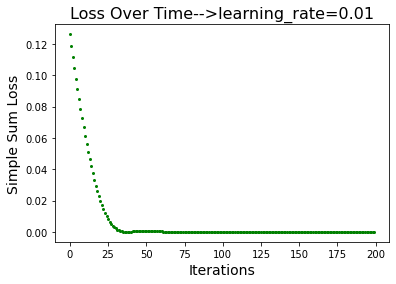

In [157]:
plt.plot(losses, "go", ms=2)
plt.title("Loss Over Time-->learning_rate=0.01", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Simple Sum Loss", fontsize=14)
#plt.ylim(-1,5)

In [158]:
losses[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=4.456524e-11>

In [15]:
p = np.array([[0.7,0.4,0.8,0.8,0.55],[0.35,0.3,0.25,0.2,0.45],[0.1,0.9,0.65,0.1,0.35],[0.2,0.15,0.95,0.65,0.9],[0.05,0.8,0.9,0.5,0.1]])

In [100]:
def trapInt(pFilt):
    b = []
    for i in np.arange(len(pFilt)):
        sum1 = 0
        sum2 = 0
        for j in np.arange(i+1):
            sum1 += pFilt[j,i]*func(j*0.25)
            if(j != 0 and j != i):
                sum2 += pFilt[j,i]*func(j*0.25)
        sum = sum1 + sum2
        integral = 0.25*0.5*sum
        b.append(func(i*0.25)-integral)
    return b

In [20]:
def func(x):
    return x*x

In [101]:
a = trapInt(p)

In [97]:
a

[0.0, 0.06015625, 0.22578125, 0.507421875, 0.83203125]

In [159]:
#print("inFilter\n", model[0].numpy())
#print("paramFilter\n", model[1].numpy())
print("b\n", model[2].numpy())

b
 [[1.0180705]
 [0.4205083]
 [1.2830153]
 [1.059206 ]
 [0.7860643]]


In [145]:
out, loss, grad = TFuSoln(tf.constant([[[[0.25]]]], dtype=tf.float32), *model, tf.ones((1,1,1,1)))
out

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.88221925]]]], dtype=float32)>